In [2]:
DEBUG = False

In [3]:
!pip -q install geffnet

You should consider upgrading via the '/opt/conda/bin/python3.7 -m pip install --upgrade pip' command.


In [4]:
import os
import sys
import time
import numpy as np
import pandas as pd
import cv2
import PIL.Image
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from tqdm.notebook import tqdm
from sklearn.metrics import roc_auc_score

import torch
from torch.utils.data import TensorDataset, DataLoader, Dataset
import torch.nn as nn
import torch.nn.functional as F
import albumentations as A
import geffnet

device = torch.device('cuda')

In [5]:
kernel_type = '9c_b7ns_1e_640_ext_15ep'
image_size = 640
use_amp = False
data_dir = '../input/jpeg-melanoma-768x768'
test_dir = '../input/mel-test'
data_dir2 = '../input/jpeg-isic2019-768x768'
model_dir = '../input/melanoma-winning-models'
enet_type = 'efficientnet-b7'
batch_size = 16
num_workers = 4
out_dim = 9

use_meta = False
use_external = '_ext' in kernel_type

# Read CSV

In [6]:
df_test = pd.read_csv(os.path.join(data_dir, 'test.csv'))
df_test['filepath'] = df_test['image_name'].apply(lambda x: os.path.join(data_dir, 'test', f'{x}.jpg'))

In [7]:
df_train = pd.read_csv(os.path.join(data_dir, 'train.csv'))
df_train = df_train[df_train['tfrecord'] != -1].reset_index(drop=True)
# df_train['fold'] = df_train['tfrecord'] % 5
tfrecord2fold = {
    2:0, 4:0, 5:0,
    1:1, 10:1, 13:1,
    0:2, 9:2, 12:2,
    3:3, 8:3, 11:3,
    6:4, 7:4, 14:4,
}
df_train['fold'] = df_train['tfrecord'].map(tfrecord2fold)
df_train['is_ext'] = 0
df_train['filepath'] = df_train['image_name'].apply(lambda x: os.path.join(data_dir, 'train', f'{x}.jpg'))

df_train['diagnosis'] = df_train['diagnosis'].apply(lambda x: x.replace('seborrheic keratosis', 'BKL'))
df_train['diagnosis'] = df_train['diagnosis'].apply(lambda x: x.replace('lichenoid keratosis', 'BKL'))
df_train['diagnosis'] = df_train['diagnosis'].apply(lambda x: x.replace('solar lentigo', 'BKL'))
df_train['diagnosis'] = df_train['diagnosis'].apply(lambda x: x.replace('lentigo NOS', 'BKL'))
df_train['diagnosis'] = df_train['diagnosis'].apply(lambda x: x.replace('cafe-au-lait macule', 'unknown'))
df_train['diagnosis'] = df_train['diagnosis'].apply(lambda x: x.replace('atypical melanocytic proliferation', 'unknown'))

df_train['diagnosis'].value_counts()

unknown     26699
nevus        5191
melanoma      581
BKL           221
Name: diagnosis, dtype: int64

In [8]:
if use_external:
    df_train2 = pd.read_csv(os.path.join(data_dir2, 'train.csv'))
    df_train2 = df_train2[df_train2['tfrecord'] >= 0].reset_index(drop=True)
    df_train2['fold'] = df_train2['tfrecord'] % 5
    df_train2['is_ext'] = 1
    df_train2['filepath'] = df_train2['image_name'].apply(lambda x: os.path.join(data_dir2, 'train', f'{x}.jpg'))

    df_train2['diagnosis'] = df_train2['diagnosis'].apply(lambda x: x.replace('NV', 'nevus'))
    df_train2['diagnosis'] = df_train2['diagnosis'].apply(lambda x: x.replace('MEL', 'melanoma'))
    df_train = pd.concat([df_train, df_train2]).reset_index(drop=True)

diagnosis2idx = {d: idx for idx, d in enumerate(sorted(df_train.diagnosis.unique()))}
df_train['target'] = df_train['diagnosis'].map(diagnosis2idx)
mel_idx = diagnosis2idx['melanoma']
diagnosis2idx

{'AK': 0,
 'BCC': 1,
 'BKL': 2,
 'DF': 3,
 'SCC': 4,
 'VASC': 5,
 'melanoma': 6,
 'nevus': 7,
 'unknown': 8}

# Dataset

In [9]:
class SIIMISICDataset(Dataset):
    def __init__(self, csv, split, mode, transform=None):

        self.csv = csv.reset_index(drop=True)
        self.split = split
        self.mode = mode
        self.transform = transform

    def __len__(self):
        return self.csv.shape[0]

    def __getitem__(self, index):
        row = self.csv.iloc[index]
        
        image = cv2.imread(row.filepath)
        image = image[:, :, ::-1]

        if self.transform is not None:
            res = self.transform(image=image)
            image = res['image'].astype(np.float32)
        else:
            image = image.astype(np.float32)

        image = image.transpose(2, 0, 1)

        if self.mode == 'test':
            return torch.tensor(image).float()
        else:
            return torch.tensor(image).float(), torch.tensor(self.csv.iloc[index].target).long()

In [10]:
transforms_val = A.Compose([
    A.Resize(image_size, image_size),
    A.Normalize()
])

In [11]:
df_show = df_train.sample(1000)
dataset_show = SIIMISICDataset(df_show, 'train', 'val', transform=transforms_val)
# dataset_show = CloudDataset(df_train, 'train', 'val', image_size, transform=None)
# dataset_show = CloudDataset(df_test, 'test', 'test', image_size, transform=None)
from pylab import rcParams
rcParams['figure.figsize'] = 20,10
for i in range(2):
    f, axarr = plt.subplots(1,5)
    for p in range(5):
        idx = np.random.randint(0, len(dataset_show))
        img, label = dataset_show[idx]
        if use_meta:
            img = img[0]
        axarr[p].imshow(img.transpose(0, 1).transpose(1,2).squeeze())
        axarr[p].set_title(str(label))

Error in callback <function flush_figures at 0x7c7c6261e320> (for post_execute):


KeyboardInterrupt: 

# Model

In [12]:
class enetv2(nn.Module):
    def __init__(self, backbone, out_dim, n_meta_features=0, load_pretrained=False):

        super(enetv2, self).__init__()
        self.n_meta_features = n_meta_features
        self.enet = geffnet.create_model(enet_type.replace('-', '_'), pretrained=load_pretrained)
        self.dropout = nn.Dropout(0.5)

        in_ch = self.enet.classifier.in_features
        self.myfc = nn.Linear(in_ch, out_dim)
        self.enet.classifier = nn.Identity()

    def extract(self, x):
        x = self.enet(x)
        return x

    def forward(self, x, x_meta=None):
        x = self.extract(x).squeeze(-1).squeeze(-1)
        x = self.myfc(self.dropout(x))
        return x

# Validation Function

In [13]:
def get_trans(img, I):
    if I >= 4:
        img = img.transpose(2,3)
    if I % 4 == 0:
        return img
    elif I % 4 == 1:
        return img.flip(2)
    elif I % 4 == 2:
        return img.flip(3)
    elif I % 4 == 3:
        return img.flip(2).flip(3)

    
def val_epoch(model, loader, is_ext=None, n_test=1, get_output=False):
    model.eval()
    LOGITS = []
    PROBS = []
    TARGETS = []
    with torch.no_grad():
        for (data, target) in tqdm(loader):
            
            if use_meta:
                data, meta = data
                data, meta, target = data.to(device), meta.to(device), target.to(device)
                logits = torch.zeros((data.shape[0], out_dim)).to(device)
                probs = torch.zeros((data.shape[0], out_dim)).to(device)
                for I in range(n_test):
                    l = model(data, meta)
                    logits += l
                    probs += l.softmax(1)
            else:
                data, target = data.to(device), target.to(device)
                logits = torch.zeros((data.shape[0], out_dim)).to(device)
                probs = torch.zeros((data.shape[0], out_dim)).to(device)
                for I in range(n_test):
                    l = model(data)
                    logits += l
                    probs += l.softmax(1)
            logits /= n_test
            probs /= n_test

            LOGITS.append(logits.detach().cpu())
            PROBS.append(probs.detach().cpu())
            TARGETS.append(target.detach().cpu())

    LOGITS = torch.cat(LOGITS).numpy()
    PROBS = torch.cat(PROBS).numpy()
    TARGETS = torch.cat(TARGETS).numpy()

    if get_output:
        return LOGITS, PROBS
    else:
        acc = (PROBS.argmax(1) == TARGETS).mean() * 100.
        auc = roc_auc_score((TARGETS==mel_idx).astype(float), LOGITS[:, mel_idx])
        auc_20 = roc_auc_score((TARGETS[is_ext==0]==mel_idx).astype(float), LOGITS[is_ext==0, mel_idx])
        return val_loss, acc, auc, auc_20

In [14]:
PROBS = []
dfs = []

for fold in range(5):
    i_fold = fold

    df_valid = df_train[df_train['fold'] == i_fold]
    if DEBUG:
        df_valid = pd.concat([
            df_valid[df_valid['target'] == mel_idx].sample(10),
            df_valid[df_valid['target'] != mel_idx].sample(10)
        ])
    print(df_valid.shape)

    dataset_valid = SIIMISICDataset(df_valid, 'train', 'val', transform=transforms_val)
    valid_loader = torch.utils.data.DataLoader(dataset_valid, batch_size=batch_size, num_workers=num_workers)

    model = enetv2(enet_type, n_meta_features=0, out_dim=out_dim)
    model = model.to(device)
    model_file = os.path.join(model_dir, f'{kernel_type}_best_fold{i_fold}.pth')
    state_dict = torch.load(model_file)
    state_dict = {k.replace('module.', ''): state_dict[k] for k in state_dict.keys()}
    model.load_state_dict(state_dict, strict=True)
    model.eval()

    this_LOGITS, this_PROBS = val_epoch(model, valid_loader, is_ext=df_valid['is_ext'].values, n_test=1, get_output=True)
    PROBS.append(this_PROBS)
    dfs.append(df_valid)
    # Save the probabilities to a CSV file for this fold
    probs_df = pd.DataFrame(this_PROBS, columns=[f'prob_class_{i}' for i in range(this_PROBS.shape[1])])
    probs_file = os.path.join(output_dir, f'probabilities_fold_{i_fold}.csv')
    probs_df.to_csv(probs_file, index=False)
    print(f'Saved probabilities for fold {i_fold} to {probs_file}')

    # Save the validation dataframe to a CSV file for this fold
    df_file = os.path.join(output_dir, f'validation_data_fold_{i_fold}.csv')
    df_valid.to_csv(df_file, index=False)
    print(f'Saved validation dataframe for fold {i_fold} to {df_file}')
    


(11589, 14)


KeyboardInterrupt: 

In [ ]:
dfs = pd.concat(dfs).reset_index(drop=True)
dfs['pred'] = np.concatenate(PROBS).squeeze()[:, mel_idx]

In [ ]:
# # Raw auc_all
# roc_auc_score(dfs['target'] == mel_idx, dfs['pred'])

In [ ]:
# # Rank per fold auc_all
# dfs2 = dfs.copy()
# for i in range(5):
#     dfs2.loc[dfs2['fold']==i, 'pred'] = dfs2.loc[dfs2['fold']==i, 'pred'].rank(pct=True)
# roc_auc_score(dfs2['target'] == mel_idx, dfs2['pred'])

In [ ]:
# # Raw auc_2020
# roc_auc_score(dfs[dfs['is_ext']==0]['target']==mel_idx, dfs[dfs['is_ext']==0]['pred'])

In [ ]:
# # Rank per fold auc_2020
# dfs2 = dfs[dfs.is_ext==0].copy()
# for i in range(5):
#     dfs2.loc[dfs2['fold']==i, 'pred'] = dfs2.loc[dfs2['fold']==i, 'pred'].rank(pct=True)
# roc_auc_score(dfs2['target'] == mel_idx, dfs2['pred'])

# Predict

In [15]:
n_test = 1
df_test = df_test if not DEBUG else df_test.head(batch_size * 2)
dataset_test = SIIMISICDataset(df_test, 'test', 'test', transform=transforms_val)
test_loader = torch.utils.data.DataLoader(dataset_test, batch_size=batch_size, num_workers=num_workers)

In [16]:
# !pip install torch_xla

In [18]:
models = []
for i_fold in range(5):
    model = enetv2(enet_type, n_meta_features=0, out_dim=out_dim)

    model_file = os.path.join(model_dir, f'{kernel_type}_best_fold{i_fold}.pth')
    state_dict = torch.load(model_file)
    state_dict = {k.replace('module.', ''): state_dict[k] for k in state_dict.keys()}
    model.load_state_dict(state_dict, strict=True)
    model = nn.DataParallel(model)  # This will wrap your model for multi-GPU
    model = model.to(device)


    model.eval()
    models.append(model)
len(models)

5

In [21]:
df_train.shape[0]

57964

In [22]:
import pandas as pd
import torch
from tqdm import tqdm
DEBUG=False
OUTPUTS = []
all_model_probabilities = []  # To store probabilities from each model
all_targets = []  # To store corresponding target values
df_train_ = df_train[:int(df_train.shape[0]*0.25)] if not DEBUG else df_train.head(batch_size * 2)
df_valid = df_train[df_train['fold'] == 0]

# Create the validation dataset and loader
dataset_valid = SIIMISICDataset(df_valid, 'train', 'val', transform=transforms_val)
valid_loader = torch.utils.data.DataLoader(dataset_valid, batch_size=32, num_workers=num_workers)

with torch.no_grad():
    for (data, target) in tqdm(valid_loader):  # Assuming target is returned from the DataLoader
        all_targets.append(target.numpy())  # Store target values

        if use_meta:
            data, meta = data
            data, meta = data.to(device), meta.to(device)
            model_probs = []  # Store probabilities for the current batch

            for I in range(n_test):
                l = model(get_trans(data, I), meta)
                model_probs.append(l.softmax(1))  # Collect probabilities from the current test

            # Average probabilities across tests
            probs = sum(model_probs) / len(model_probs)
            print(all_model_probabilities.shape)
            all_model_probabilities.append(probs.detach().cpu().numpy())  # Save averaged probabilities
        else:
            data = data.to(device)
            model_probs = []  # List to store probabilities from each model
#             model_probs_for_current_model = []
            for model_index, model in enumerate(models):
                
#                 for I in range(n_test):
                l = model(data)
#                 print(l.softmax(1).detach().cpu().numpy()[:,6].shape)
                model_probs.append(l.softmax(1).detach().cpu().numpy()[:,6])  # Collect probabilities
#             averaged_probs = sum(model_probs_for_current_model) / len(model_probs_for_current_model)
#             model_probs.append(model_probs_for_current_model)  # Store for this model
            all_model_probabilities.append(np.array(model_probs).T)  # Append to all model probs


100%|██████████| 363/363 [45:05<00:00,  7.45s/it]


In [ ]:
# all_model_probabilities_flattened[:,0]

In [ ]:
# all_model_probabilities_flattened

In [ ]:
# all_model_probabilities[0]

In [ ]:
# len(all_model_probabilities[0][2][:, 6])

In [ ]:
# all_model_probabilities=np.concatenate(all_model_probabilities, axis=0)
# all_model_probabilities

In [23]:
all_model_probabilities.shape

AttributeError: 'list' object has no attribute 'shape'

In [ ]:
# len(flat_model_probabilities[0])

In [ ]:
all_model_probabilities

In [24]:
all_model_probabilities_copy=all_model_probabilities.copy()

In [26]:
all_targets_copy=all_targets.copy()

In [ ]:
flat_model_probabilities.shape

In [27]:
# Concatenate all model probabilities and targets
flat_model_probabilities = np.concatenate(all_model_probabilities_copy, axis=0)

# all_model_probabilities = np.array(all_model_probabilities)  # Shape (n_batches * n_models, n_classes)
all_targets_copy = np.concatenate(all_targets_copy)  # Flatten the target array

# Create a DataFrame to save probabilities for each model
num_models = len(models) if not use_meta else 1  # Number of models
columns = []
for m in range(num_models):
#     for i in range(all_model_probabilities.shape[1]):  # Loop through classes
    columns.append(f'model_{m+1}_prob_class_{i}')  # Class probabilities for each model

# Prepare the DataFrame
probabilities_df = pd.DataFrame(flat_model_probabilities, columns=columns)
probabilities_df['target'] = all_targets_copy  # Add targets to the DataFrame

# Save the DataFrame to a CSV file
probabilities_df.to_csv('model_probabilities_validation.csv', index=False)
print('Saved model-specific probabilities and corresponding targets to model_probabilities_validation.csv')


Saved model-specific probabilities and corresponding targets to model_probabilities_validation.csv


[12:22:31] WARNING: /workspace/src/learner.cc:480: 
Parameters: { use_label_encoder } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


Accuracy: 0.99
              precision    recall  f1-score   support

           0       1.00      0.99      0.99      2127
           1       0.93      0.95      0.94       191

    accuracy                           0.99      2318
   macro avg       0.96      0.97      0.97      2318
weighted avg       0.99      0.99      0.99      2318

ROC AUC Score: 1.00


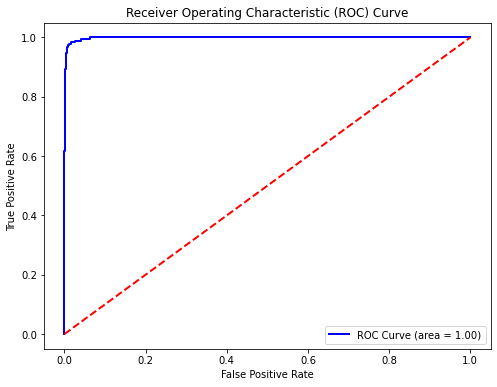

In [30]:
import pandas as pd
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, classification_report, roc_auc_score, roc_curve
import matplotlib.pyplot as plt

# Load your CSV data
data = pd.read_csv('model_probabilities_validation.csv')  # Replace 'your_file.csv' with your actual CSV file name

# Convert target values: 6 -> 1, others -> 0
data['target'] = data['target'].apply(lambda x: 1 if x == 6 else 0)

# Define feature columns and target
X = data.drop(columns=['target'])  # All columns except 'target'
y = data['target']  # Target variable

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize and train the XGBoost classifier
model = XGBClassifier(use_label_encoder=False, eval_metric='logloss')
model.fit(X_train, y_train)

# Make predictions and predict probabilities
y_pred = model.predict(X_test)
y_pred_proba = model.predict_proba(X_test)[:, 1]  # Probability of class 1

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy:.2f}')
print(classification_report(y_test, y_pred))

# Calculate ROC AUC score
roc_auc = roc_auc_score(y_test, y_pred_proba)
print(f'ROC AUC Score: {roc_auc:.2f}')

# Plot ROC Curve
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label='ROC Curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='red', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()


In [51]:
df_test = pd.read_csv(os.path.join(data_dir, 'test.csv'))
df_test['filepath'] = df_test['image_name'].apply(lambda x: os.path.join(data_dir, 'test', f'{x}.jpg'))
n_test = 1
df_test = df_test if not False else df_test.head(batch_size * 2)
dataset_test = SIIMISICDataset(df_test, 'test', 'test', transform=transforms_val)
test_loader = torch.utils.data.DataLoader(dataset_test, batch_size=batch_size, num_workers=num_workers)

In [52]:
df_test.shape

(10982, 8)

In [53]:
models = []
for i_fold in range(5):
    model = enetv2(enet_type, n_meta_features=0, out_dim=out_dim)
#     model = model.to(device)
    model_file = os.path.join(model_dir, f'{kernel_type}_best_fold{i_fold}.pth')
    state_dict = torch.load(model_file)
    state_dict = {k.replace('module.', ''): state_dict[k] for k in state_dict.keys()}
    model.load_state_dict(state_dict, strict=True)
    model = nn.DataParallel(model)  # This will wrap your model for multi-GPU
    model = model.to(device)
    model.eval()
    models.append(model)
len(models)

5

In [ ]:
OUTPUTS = []
PROBS = []
all_model_probabilities_test=[]
with torch.no_grad():
    for (data) in tqdm(test_loader):

        if False:
            data, meta = data
            data, meta = data.to(device), meta.to(device)
            probs = torch.zeros((data.shape[0], out_dim)).to(device)
            for I in range(n_test):
#                 l = model(get_trans(data, I), meta)
                probs += l.softmax(1)
        else:
            data = data.to(device)
            probs = torch.zeros((data.shape[0], out_dim)).to(device)
            model_probs = []  # List to store probabilities from each model

            for model in models:
#                 for I in range(n_test):
#                 l = model(get_trans(data, I))
#                     probs += l.softmax(1)
                l = model(data)
#                 print(l.softmax(1).detach().cpu().numpy()[:,6].shape)
                model_probs.append(l.softmax(1).detach().cpu().numpy()[:,6])  # Collect probabilities
#             averaged_probs = sum(model_probs_for_current_model) / len(model_probs_for_current_model)
#             model_probs.append(model_probs_for_current_model)  # Store for this model
            all_model_probabilities_test.append(np.array(model_probs).T)  # Append to all model probs


#         probs /= n_test * len(models)
#         PROBS.append(probs.detach().cpu())

# PROBS = torch.cat(PROBS).numpy()
# OUTPUTS = PROBS[:, mel_idx]

 12%|█▏        | 85/687 [05:24<38:03,  3.79s/it]

In [50]:
all_model_probabilities_test

[array([[1.4332974e-03, 3.9813625e-05, 2.0852462e-05, 3.6451500e-05,
         3.8535378e-05],
        [3.3528067e-03, 8.4238323e-05, 2.0889577e-04, 3.7552169e-04,
         2.2341085e-03],
        [3.4661621e-03, 1.2390408e-05, 4.4331646e-05, 3.2808591e-04,
         2.4131768e-05],
        [1.6218823e-04, 7.4643227e-05, 8.0039412e-05, 2.6243957e-04,
         2.1923262e-04],
        [1.2392391e-04, 4.0037744e-04, 4.3028803e-03, 1.6299343e-06,
         6.2806316e-04],
        [6.5535353e-04, 1.6583971e-03, 9.3829143e-04, 1.1114702e-03,
         4.2736123e-04],
        [1.7888865e-02, 1.0879695e-01, 1.5873444e-04, 2.5125366e-04,
         1.0837554e-02],
        [2.0255674e-02, 1.3072089e-02, 5.2609846e-02, 3.7005939e-02,
         2.0675283e-02],
        [2.5350433e-03, 3.9499500e-04, 3.3977069e-04, 4.3481067e-04,
         4.8999860e-05],
        [2.7281302e-03, 1.3791849e-03, 2.0783956e-03, 2.9566265e-03,
         9.2313979e-03],
        [3.4466240e-05, 1.7066066e-06, 4.8767997e-06, 1.8320

In [ ]:
OUTPUTS = []
PROBS = []
dataset_valid = SIIMISICDataset(df_train, 'train', 'val', transform=transforms_val)
valid_loader = torch.utils.data.DataLoader(dataset_valid, batch_size=batch_size, num_workers=num_workers)
with torch.no_grad():
    for (data) in tqdm(valid_loader):

        if use_meta:
            data, meta = data
            data, meta = data.to(device), meta.to(device)
            probs = torch.zeros((data.shape[0], out_dim)).to(device)
            for I in range(n_test):
                l = model(get_trans(data, I), meta)
                probs += l.softmax(1)
        else:
            data[0] = data[0].to(device)
            data[1] = data[1].to(device)

            probs = torch.zeros((data.shape[0], out_dim)).to(device)
            for model in models:
                for I in range(n_test):
                    l = model(data)
                    probs += l.softmax(1)

        probs /= n_test * len(models)
        PROBS.append(probs.detach().cpu())

PROBS = torch.cat(PROBS).numpy()
OUTPUTS = PROBS[:, mel_idx]

In [ ]:
import pandas as pd
import torch
from tqdm import tqdm

# Assuming 'models' is a list of your trained models
OUTPUTS = []
all_model_probabilities = []  # List to store probabilities from each model
all_targets = []  # To store corresponding target values

with torch.no_grad():
    for (data, target) in tqdm(test_loader):
        # Store target values
        all_targets.append(target.numpy())  # Convert target to numpy

        if use_meta:
            data, meta = data
            data, meta = data.to(device), meta.to(device)
            model_probs = []
            for I in range(n_test):
                l = model(get_trans(data, I), meta)
                model_probs.append(l.softmax(1))
            probs = sum(model_probs) / len(model_probs)  # Average across tests
            # Store the model's probabilities
            all_model_probabilities.append(probs.detach().cpu().numpy())
        else:
            data = data.to(device)
            model_probs = []  # List to store each model's probabilities
            for model_index, model in enumerate(models):
                model_probs_for_current_model = []
                for I in range(n_test):
                    l = model(data)
                    model_probs_for_current_model.append(l.softmax(1))  # Store for this model
                # Average probabilities for the current model
                averaged_probs = sum(model_probs_for_current_model) / len(model_probs_for_current_model)
                model_probs.append(averaged_probs.detach().cpu().numpy())  # Store for this model
                all_model_probabilities.append(averaged_probs.detach().cpu().numpy())  # Append to all model probs

# Concatenate all model probabilities and targets
all_model_probabilities = np.array(all_model_probabilities)  # Shape (n_models, n_samples, n_classes)
all_targets = np.concatenate(all_targets)  # Flatten the target array

# Create a DataFrame to save probabilities for each model
columns = []
for m in range(len(models)):
    for i in range(all_model_probabilities.shape[1]):  # Loop through samples
        columns.append(f'model_{m+1}_prob_class_{i}')  # Class probabilities for each model

# Prepare the DataFrame
probabilities_df = pd.DataFrame(all_model_probabilities.reshape(-1, all_model_probabilities.shape[1]), columns=columns)
probabilities_df['target'] = all_targets  # Add targets to the DataFrame

# Save the DataFrame to a CSV file
probabilities_df.to_csv('model_probabilities_with_targets.csv', index=False)
print('Saved model-specific probabilities and corresponding targets to model_probabilities_with_targets.csv')


In [ ]:
df_test['target'] = OUTPUTS
df_test[['image_name', 'target']].to_csv(f'submission.csv', index=False)

In [ ]:
df_test[['image_name', 'target']].head()

In [ ]:
df_test.shape

# Infer Single Image

In [ ]:
#patient test images processing
# patient 1 image name
in1 = 'hello'
# patient 1 patient_id
pi1 = 'IP23235'
# patient 1 sex
s1 = 'female'
# patient 1 age
a1 = 20.0
# patient 1 anatom_site_general_challenge. where its located
asgc1 = 'torso'
# patient 1 image filepath
f1 = '../input/melanoma/30.jpg'
import csv
with open('datasettesting.csv', 'w', newline='') as file:
    writer = csv.writer(file)
    writer.writerow(["image_name", "patient_id", "sex", "age_approx", "anatom_site_general_challenge", "width", "height", "filepath"])
    writer.writerow([in1,pi1, s1, a1, asgc1, 768, 768, f1])

In [ ]:
df_single_image = pd.read_csv('datasettesting.csv')
df_single_image

In [ ]:
# as we only read a single image, so we don't need a dataloader
dataset_test = SIIMISICDataset(df_single_image, 'test', 'test', transform=transforms_val)
image = dataset_test[0]  
image = image.to(device).unsqueeze(0)  # a single image need to be added a new axis to act like batch_size = 1

In [ ]:
with torch.no_grad():
    probs = torch.zeros((image.shape[0], out_dim)).to(device)
    for model in models:
        for I in range(n_test):
            l = model(get_trans(image, I))
            probs += l.softmax(1)
probs /= len(models) * n_test

In [ ]:
prediction = probs[:, mel_idx].item()
prediction

In [ ]:
PROBS